# What's  Cooking Project - Part2
### by Pauline Gerritsen, Shubhada Gopale, Stanislav Ivashkevich, Sumithra Hariguruprasad

## Introduction

We explored the data in the What's_cooking_Part1 notebook. Now lets do some modelling.
In order to prepare the data for modelling we need to follow the following steps:
1. Separate each ingredient in each recipe.
2. Remove all the numbers, special characters, non relevant words.
3. Find the root of the ingredients. I.e. combine ingredients like tomatoes and tomato into one.
4. Get count of each of the ingredient words in each recipe.
5. Create a vector having all the ingredients combined from all the recipes. Create a vector representation for each recipe.
6. Encode the cuisine categories.
7. Pass these X vector, y to models.

General Steps for Text Processing:
1. Lower casing - Lowercasing ALL your text data
2. Stemming - Stemming is the process of reducing inflection in words (e.g. troubled, troubles) to their root form (e.g. trouble). The “root” in this case may not be a real root word, but just a canonical form of the original word. Stemming uses a crude heuristic process that chops off the ends of words in the hope of correctly transforming words into its root form. So the words “trouble”, “troubled” and “troubles” might actually be converted to troubl instead of trouble because the ends were just chopped off. Most common algorith for stemming is Porter's algorithm.
3. Stopword Removal - Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc. The intuition behind using stop words is that, by removing low information words from text, we can focus on the important words instead. In our case it helps remove non relevant words like numbers, units, other words like fresh, add, country etc. It does help reduce the number of features.
4. Tokenization - Tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators. The CountVectorizer/TfidfVectoriser have this inbuilt.
5. Counting the occurrences of tokens in each document. Each individual token occurrence frequency (normalized or not) is treated as a feature. The CountVectoriser does this.
6. normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents. TfidfVectorizer does this.
We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document. 
5. Train model with these vectors and evaluate.


### Import libraries

In [ ]:
# Import the required libraries 

import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

#Splitting the dataset
from sklearn.model_selection import train_test_split

#Text extraction
from nltk.stem import PorterStemmer # for finding the root words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#Classifiers
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

#Pipeline
from sklearn.pipeline import Pipeline

#Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Imbalanced dataset
from imblearn.over_sampling import SMOTE

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Load dataset

In [ ]:
#Import data

train = pd.read_json('train.json')

##### The 'Ingredients' column is a list, converting it to normal string for processing

In [ ]:
train['separated_ingredients'] = train['ingredients'].apply(','.join)
train.head(5)

,cuisine,id,ingredients,separated_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,indian,22213,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper..."


#### Outliers removal

Since only 22 recipes can be considered as outliers we are not removing them.

##### Saving the target variable separately

In [ ]:
target = train.cuisine

##### This is our custom stopword list which has all the words we think are not relevant in classifying the cuisine

In [ ]:
stopwords = ['oz', 'ml', 'lb', 'g','kg','ground', 'fresh', 'accompaniment', 'acting', 'added', 'aka','all',
             'an', 'and', 'any','ao', 'au','based','beaters','beaten','bee', 'believe','believ','best','blade',
            'boil','bottle','bottled','bottom','bottoms','bought', 'brand','broad', 'california', 'calorie',
             'campbell', 'center', 'challenge', 'classic', 'cloud', 'club', 'collect', 'comfort',
            'compressed', 'con', 'concentrate', 'cooking', 'country', 'covered', 'culinary', 'cut', 'cuts', 'diamond', 
            'diced', 'diet', 'digestive', 'dinner', 'dinosaur', 'disco', 'dish', 'distilled', 'do', 'domino', 'double', 'doubl',
            'drain', 'drained', 'dress', 'drink', 'energy', 'english', 'equal', 'extra', 'farm', 'farmer', 'farms', 'fashioned',
            'fast', 'fatfree', 'field', 'filled', 'fine', 'finely', 'firm', 'firmly', 'flat', 'fluff', 'food', 'forest', 'for',
            'four', 'free', 'freshly', 'full', 'fully', 'giant', 'good', 'grade', 'grand', 'granny', 'grated', 'grating', 'hair',
            'half', 'hand', 'hidden','home','homemade','homestyl','hothouse', 'imitation', 'imperial', 'in', 'inch', 'instant',
            'into','island','islands','it','kitchen','lady','land','layer','less','light','lite','low','lowfat','lower','made',
            'mary','me','mild','mince','mini','miniature','minute','miracle','mix','mrs','natural','new','no','nonfat',
            'nonstick','of','old','on','one','or','oven','pain','pan','paper','part','parts','peel','peeled', 'piece', 'pieces',
            'plus','pot','pound','prebaked','precooked','premium','prepared', 'prepar','promise','pure','quick','ready','real',
            'regular', 'rich','serving','short','side','simple','size','stir','store','straight','success','thousand','to',
            'well','wok','world',]

##### This step will only extract the words from the ingredients list and ignore all special characters or numbers. For each recipe it will give the ingredients separately in one sentence


In [ ]:
x = [re.sub('[^a-zA-Z]',' ',doc) for doc in train['separated_ingredients'] ]

##### We need to split each sentence into list of words for each recipe

In [ ]:
document = [doc.split() for doc in x ] 

#### Stemming function

In [ ]:
# Defining our stemmer
ps = PorterStemmer()

# This function will convert the word to lowercase and return the stem of each word. 
# It will ignore the words present in stopwords
def convert(words) :
  
    current_words = list()
    for i in words :
        if i.lower() not in stopwords :
            
            updated_word = ps.stem(i)
            current_words.append(updated_word.lower())
    return current_words

In [ ]:
# Call the function convert to do the stemming of the words. The document is updated inplace
document = [ convert(doc)   for doc in document ] 

In [ ]:
# Again join the words into sentences
document = [ " ".join(doc) for doc in document] 

#### Encoding the Cuisines

In [ ]:
# The column 'Cuisine' is the target variable. Use LabelEncoder to label the multiple classes
lb = LabelEncoder()
y = lb.fit_transform(target)

In [ ]:
lb.classes_

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

#### Split dataset into train and test

In [ ]:
#Write a code to split your dataset into 70/30 dataset
xtrain , xtest , y_train , y_test = train_test_split(document,y,test_size=0.3, random_state=42)

In [ ]:
print(len(xtrain), len(xtest), len(y_train), len(y_test))

27841 11933 27841 11933


In [ ]:
## Modelling

#### Lets try a few classifiers using a pipeline to select the best scoring

In [ ]:
#Defining a pipeline

pipeline = Pipeline([
    ('Countvect', CountVectorizer(analyzer='word', stop_words=stopwords)), #Step1 - count vectoriser
    ('clf', LogisticRegression())                                          #Step2 - classifier
])

#Select classifiers to try
clfs = []
clfs.append(LogisticRegression(multi_class='multinomial', solver='lbfgs', C=5, max_iter=800))
clfs.append(LinearSVC())
clfs.append(DecisionTreeClassifier(max_depth=15))
clfs.append(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=42))
clfs.append(MultinomialNB())

In [ ]:
for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, xtrain, y_train, return_train_score=True,cv=3)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    print('mean train accuracy ', scores['train_score'].mean())
    print('mean test accuracy ', scores['test_score'].mean())

---------------------------------
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=800,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------
mean train accuracy  0.9037929625095589
mean test accuracy  0.7584851478318426


C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


---------------------------------
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
-----------------------------------
mean train accuracy  0.8880249943080188
mean test accuracy  0.7618611487131313
---------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
-----------------------------------
mean train accuracy  0.6024385008895584
mean test accuracy  0.5390998285569897
---------------------------------
RandomForestClassifier(bootstrap=Tr

In [ ]:
###### At first glance MultinomialNB is giving best results without overfitting. Logistic and LinearSVC seems to overfit a bit. There seems room for improvement for Randomforest

In [ ]:
### Lets try the pipeline with TfidfVectoriser, which will give weight to less frequent words

In [ ]:
#Lets try th same with Tfidf
pipeline_tf = Pipeline([
    ('Tfvect', TfidfVectorizer(analyzer='word', stop_words=stopwords)), #Step1 - Tfidf vectoriser
    ('clf', LogisticRegression())                                       #Step2 - classifier
])

for classifier in clfs:
    pipeline_tf.set_params(clf = classifier)
    scores = cross_validate(pipeline_tf, xtrain, y_train, return_train_score=True)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    print('mean train accuracy ', scores['train_score'].mean())
    print('mean test accuracy ', scores['test_score'].mean())

---------------------------------
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=800,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
-----------------------------------
mean train accuracy  0.8667254992643301
mean test accuracy  0.7774153532103232
---------------------------------
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
-----------------------------------
mean train accuracy  0.8673363008201029
mean test accuracy  0.7779892560167404
---------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
                       max_featur

##### We can see that using the TfidfVectorizer improved the scores so we will continue rest of the steps using this.

### Hyperparamater Tuning

In [ ]:
#Filter out stop words
tf_vect = TfidfVectorizer(analyzer='word', stop_words=stopwords)
X_train = tf_vect.fit_transform(xtrain)
X_test = tf_vect.transform(xtest)


In [ ]:
X_train.shape, X_test.shape

((27841, 2292), (11933, 2292))

#### Logistic classifier

In [ ]:
param_grid_LR = [{'C': [1, 2, 5], 'max_iter': [600, 800]}]
grid_search_lr = GridSearchCV(LogisticRegression(multi_class='multinomial', solver='lbfgs'), param_grid_LR, cv=5, 
                              scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
print(grid_search_lr.best_params_)
print(grid_search_lr.best_score_)

{'C': 5, 'max_iter': 600}
0.7812578571172013


In [ ]:
log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=5, max_iter=600)
scores = cross_validate(log_clf, X_train, y_train, return_train_score=True,cv=5)
print('-----------------------------------------')
print('Logistic')
print('-----------------------------------------')
print('mean train accuracy ', scores['train_score'].mean())
print('mean validation accuracy ', scores['test_score'].mean())

log_clf.fit(X_train,y_train)
y_pred_tr = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

print("Logistic test:", accuracy_score(y_test, y_pred))
print('-----------------------------------------')

-----------------------------------------
Logistic
-----------------------------------------
mean train accuracy  0.8616700216909292
mean validation accuracy  0.7812575947149337
Logistic test: 0.7857202715159641
-----------------------------------------


In [ ]:
# Creating array with cuisine names
label = pd.DataFrame(lb.classes_, columns=['cuisine'])
target_names = label.cuisine.values

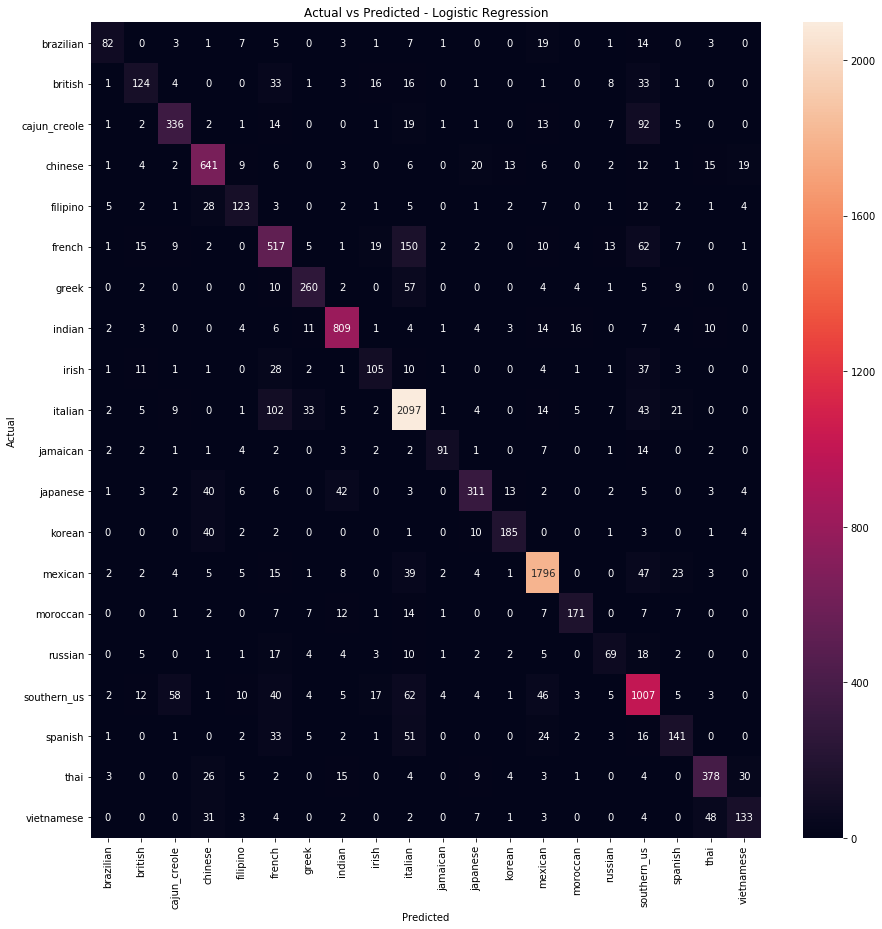

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_title('Actual vs Predicted - Logistic Regression')
plt.show()


In [ ]:
print(classification_report(y_test,  y_pred, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.77      0.56      0.65       147
     british       0.65      0.51      0.57       242
cajun_creole       0.78      0.68      0.72       495
     chinese       0.78      0.84      0.81       760
    filipino       0.67      0.61      0.64       200
      french       0.61      0.63      0.62       820
       greek       0.78      0.73      0.76       354
      indian       0.88      0.90      0.89       899
       irish       0.62      0.51      0.56       207
     italian       0.82      0.89      0.85      2351
    jamaican       0.86      0.67      0.76       135
    japanese       0.82      0.70      0.75       443
      korean       0.82      0.74      0.78       249
     mexican       0.90      0.92      0.91      1957
    moroccan       0.83      0.72      0.77       237
     russian       0.57      0.48      0.52       144
 southern_us       0.70      0.78      0.74      1289
     spanish       0.61    

#### Multinomial Naive Bayes classifier

In [ ]:
param_grid_MNB = [{'alpha': [1, 0.1, 0.01, 0.001]}]
grid_search_mnb = GridSearchCV(MultinomialNB(), param_grid_MNB, cv=5, 
                              scoring='accuracy')
grid_search_mnb.fit(X_train, y_train)
print(grid_search_mnb.best_params_)
print(grid_search_mnb.best_score_)

{'alpha': 0.01}
0.7327682195323444


In [ ]:
mnb_clf = MultinomialNB(alpha=0.01)
scores = cross_validate(mnb_clf, X_train, y_train, return_train_score=True,cv=5)
print('-----------------------------------------')
print('Multinomial Naive Bayes')
print('-----------------------------------------')
print('mean train accuracy ', scores['train_score'].mean())
print('mean validation accuracy ', scores['test_score'].mean())
mnb_clf.fit(X_train,y_train)
#y_pred_tr = mnb_clf.predict(X_train)
y_pred_mnb = mnb_clf.predict(X_test)
print('-----------------------------------------')

print("Naive Bayes test:", accuracy_score(y_test, y_pred_mnb))
print('-----------------------------------------')

-----------------------------------------
Multinomial Naive Bayes
-----------------------------------------
mean train accuracy  0.7872201269692269
mean validation accuracy  0.7327661455939475
-----------------------------------------
Naive Bayes test: 0.7315846811363446
-----------------------------------------


In [ ]:
print(classification_report(y_test,  y_pred_mnb, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.79      0.44      0.57       147
     british       0.60      0.35      0.44       242
cajun_creole       0.72      0.63      0.67       495
     chinese       0.68      0.87      0.77       760
    filipino       0.83      0.41      0.55       200
      french       0.55      0.52      0.54       820
       greek       0.78      0.55      0.65       354
      indian       0.83      0.87      0.85       899
       irish       0.67      0.32      0.43       207
     italian       0.75      0.88      0.81      2351
    jamaican       0.84      0.51      0.64       135
    japanese       0.83      0.60      0.70       443
      korean       0.87      0.58      0.70       249
     mexican       0.86      0.90      0.88      1957
    moroccan       0.85      0.64      0.73       237
     russian       0.56      0.34      0.42       144
 southern_us       0.57      0.77      0.66      1289
     spanish       0.67    

#### SVM classifier

In [ ]:
param_grid_svc = [{'C': [0.01, 0.1, 1]}]
grid_search_svc = GridSearchCV(LinearSVC(), param_grid_svc, cv=5, 
                              scoring='accuracy')
grid_search_svc.fit(X_train, y_train)
print(grid_search_svc.best_params_)
print(grid_search_svc.best_score_)

{'C': 1}
0.7817607126180812


In [ ]:
svc_clf = LinearSVC(C=1)
scores = cross_validate(svc_clf, X_train, y_train, return_train_score=True,cv=5)
print('-----------------------------------------')
print('LinearSVC')
print('-----------------------------------------')
print('mean train accuracy ', scores['train_score'].mean())
print('mean validation accuracy ', scores['test_score'].mean())
svc_clf.fit(X_train,y_train)
#y_pred_tr = mnb_clf.predict(X_train)
y_pred_svc = svc_clf.predict(X_test)
print('-----------------------------------------')

print("Test Accuracy:", accuracy_score(y_test, y_pred_svc))
print('-----------------------------------------')

-----------------------------------------
LinearSVC
-----------------------------------------
mean train accuracy  0.8607179038071895
mean validation accuracy  0.7817608304572732
-----------------------------------------
Test Accuracy: 0.7828710299170368
-----------------------------------------


In [ ]:
print(classification_report(y_test,  y_pred_svc, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.72      0.54      0.62       147
     british       0.67      0.49      0.56       242
cajun_creole       0.77      0.68      0.72       495
     chinese       0.77      0.84      0.80       760
    filipino       0.69      0.56      0.62       200
      french       0.63      0.63      0.63       820
       greek       0.76      0.74      0.75       354
      indian       0.86      0.90      0.88       899
       irish       0.63      0.45      0.53       207
     italian       0.82      0.90      0.85      2351
    jamaican       0.80      0.67      0.73       135
    japanese       0.83      0.70      0.76       443
      korean       0.82      0.74      0.78       249
     mexican       0.90      0.92      0.91      1957
    moroccan       0.82      0.71      0.76       237
     russian       0.57      0.47      0.52       144
 southern_us       0.70      0.79      0.74      1289
     spanish       0.62    

#### Random Forest classifier

In [ ]:

rnd_clf = RandomForestClassifier(n_jobs=-1,n_estimators=50, oob_score = True, max_depth=20)

In [ ]:
param_grid = { 
    'n_estimators': [100,500,1000, 1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 15, 20]
}


In [ ]:
#Search for best parameters for Random Forest
CV_rfc = GridSearchCV(estimator=rnd_clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=20,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True, random_state=None,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_dep

In [ ]:
print(CV_rfc.best_params_)

{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 1500}


In [ ]:
#Rerun RandomForest Classifier with new parameters
rnd_clf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', max_depth=20, random_state=42)

rnd_clf.fit(X_train, y_train)
y_pred_tr = rnd_clf.predict(X_train)
y_pred_rnd = rnd_clf.predict(X_test)
print("--------------------------------------------------------------------------")
print("RandomForest train:", accuracy_score(y_train, rnd_clf.predict(X_train)))
print("RandomForest test:", accuracy_score(y_test, y_pred_rnd))
print("--------------------------------------------------------------------------")


--------------------------------------------------------------------------
RandomForest train: 0.73837146654215
RandomForest test: 0.6440962038045756
--------------------------------------------------------------------------


In [ ]:
print(classification_report(y_test,  y_pred_rnd, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       1.00      0.16      0.27       147
     british       0.00      0.00      0.00       242
cajun_creole       0.89      0.48      0.62       495
     chinese       0.63      0.88      0.73       760
    filipino       1.00      0.09      0.16       200
      french       0.79      0.15      0.25       820
       greek       0.91      0.32      0.48       354
      indian       0.80      0.84      0.82       899
       irish       0.00      0.00      0.00       207
     italian       0.52      0.95      0.67      2351
    jamaican       1.00      0.24      0.39       135
    japanese       0.95      0.47      0.63       443
      korean       0.96      0.37      0.54       249
     mexican       0.79      0.90      0.84      1957
    moroccan       0.94      0.38      0.54       237
     russian       1.00      0.01      0.03       144
 southern_us       0.49      0.70      0.57      1289
     spanish       1.00    

C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\maleg\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
##### The RandomForest classifier seems to be overfitting. And it is not better than the logistic classifier or SVC. So we will not look into this more.

##### Comparing the precision/recall across the various cuisine for the three classifiers Logistic, MNB and SVC we can see that the MNB has less precision for the minority classes. The Logistic and SVC are equally good across various cuisine, the minimum precision is 59% for Russian Cuisine and highest is 90% for Mexican cuisine. Next lets try the Voting Classifier with the above 3 classifiers to see if we can improve our scores.

#### Voting Classifier

In [ ]:
# Lets try using a voting Classifier for our 3 best classifiers
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('mnb', mnb_clf), ('svc', svc_clf)],
        voting='hard'
    )
voting_clf.fit(X_train, y_train)

print('Train accuracy:', accuracy_score(y_train, voting_clf.predict(X_train)))
y_pred_voting = voting_clf.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_voting))

Train accuracy: 0.8531661937430408
Test accuracy: 0.7835414397050197


In [ ]:
print(classification_report(y_test,  y_pred_voting, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.71      0.55      0.62       147
     british       0.62      0.50      0.55       242
cajun_creole       0.76      0.69      0.72       495
     chinese       0.76      0.86      0.80       760
    filipino       0.70      0.58      0.64       200
      french       0.61      0.64      0.62       820
       greek       0.78      0.73      0.75       354
      indian       0.87      0.90      0.88       899
       irish       0.62      0.44      0.52       207
     italian       0.81      0.90      0.85      2351
    jamaican       0.87      0.67      0.76       135
    japanese       0.84      0.69      0.76       443
      korean       0.83      0.73      0.78       249
     mexican       0.90      0.92      0.91      1957
    moroccan       0.84      0.72      0.77       237
     russian       0.58      0.44      0.50       144
 southern_us       0.69      0.79      0.74      1289
     spanish       0.62    

##### The Voting Classifier only slightly improved the accuracy.

### SMOTE

In [ ]:
# Our dataset is imbalanced with maximum recipes for Italian, Mexican and Souther_US. 
# Lets see if SMOTE help us improve our results
X = X_train
y = y_train

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

#### Logistic Classifier

In [ ]:
clf1 = log_clf.fit(X_res, y_res)
y_pred1 = log_clf.predict(X_test) 

print("Logistic train:",clf1.__class__.__name__, accuracy_score(y_res, clf1.predict(X_res)))
print("Logistic test:",clf1.__class__.__name__, accuracy_score(y_test, y_pred1))
print("==================================================================")

Logistic train: LogisticRegression 0.920393657736468
Logistic test: LogisticRegression 0.7473393111539428


In [ ]:
print(classification_report(y_test, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.50      0.66      0.57       147
     british       0.44      0.62      0.51       242
cajun_creole       0.68      0.74      0.71       495
     chinese       0.83      0.76      0.79       760
    filipino       0.55      0.69      0.61       200
      french       0.59      0.62      0.61       820
       greek       0.67      0.80      0.72       354
      indian       0.89      0.83      0.86       899
       irish       0.41      0.61      0.49       207
     italian       0.90      0.77      0.83      2351
    jamaican       0.60      0.73      0.66       135
    japanese       0.72      0.73      0.72       443
      korean       0.73      0.77      0.75       249
     mexican       0.94      0.86      0.90      1957
    moroccan       0.71      0.78      0.74       237
     russian       0.33      0.57      0.42       144
 southern_us       0.79      0.68      0.73      1289
     spanish       0.39    

#### LinearSVC Classifier

In [ ]:
clf3 = svc_clf.fit(X_res, y_res)
y_pred3 = svc_clf.predict(X_test)

print("SVC train SMOTE:",clf3.__class__.__name__, accuracy_score(y_res, clf3.predict(X_res)))
print("SVC test SMOTE:",clf3.__class__.__name__, accuracy_score(y_test, y_pred3))
print("==================================================================")
    

SVC train SMOTE: LinearSVC 0.9100965919445964
SVC test SMOTE: LinearSVC 0.743568256096539


In [ ]:
print(classification_report(y_test,  y_pred3, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.46      0.64      0.54       147
     british       0.42      0.62      0.50       242
cajun_creole       0.69      0.75      0.72       495
     chinese       0.83      0.76      0.79       760
    filipino       0.52      0.67      0.59       200
      french       0.60      0.61      0.60       820
       greek       0.64      0.79      0.71       354
      indian       0.88      0.83      0.85       899
       irish       0.40      0.61      0.48       207
     italian       0.90      0.77      0.83      2351
    jamaican       0.60      0.74      0.66       135
    japanese       0.73      0.73      0.73       443
      korean       0.72      0.77      0.74       249
     mexican       0.93      0.86      0.89      1957
    moroccan       0.67      0.77      0.72       237
     russian       0.34      0.59      0.43       144
 southern_us       0.79      0.66      0.72      1289
     spanish       0.39    

#### Voting Classifier

In [ ]:
voting_clf.fit(X_res, y_res)
print(accuracy_score(y_res, voting_clf.predict(X_res)))
print(accuracy_score(y_test, voting_clf.predict(X_test)))

0.9125751776927282
0.7495181429648873


In [ ]:
print(classification_report(y_test,  voting_clf.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.46      0.65      0.54       147
     british       0.39      0.64      0.48       242
cajun_creole       0.66      0.77      0.71       495
     chinese       0.81      0.79      0.80       760
    filipino       0.56      0.69      0.62       200
      french       0.58      0.62      0.60       820
       greek       0.65      0.81      0.72       354
      indian       0.89      0.84      0.86       899
       irish       0.42      0.60      0.50       207
     italian       0.91      0.77      0.83      2351
    jamaican       0.63      0.74      0.68       135
    japanese       0.76      0.71      0.74       443
      korean       0.75      0.77      0.76       249
     mexican       0.94      0.86      0.90      1957
    moroccan       0.72      0.77      0.74       237
     russian       0.35      0.58      0.44       144
 southern_us       0.80      0.67      0.73      1289
     spanish       0.41    

##### Balancing the dataset has not really improved our models.

### Dimensionality Reduction

In [ ]:
#PCA does not support sparse input. So we useTruncatedSVD as a alternative.
from sklearn.decomposition import TruncatedSVD
# We reduce the features to 1000
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd.fit(X_train)  

print('Explained variance sum: ',svd.explained_variance_ratio_.sum())  


Explained variance sum:  0.9665488331124685


In [ ]:
# The explained variance is 99%, so we can use the above svd to reduce our number of features
X_train_reduced = svd.transform(X_train)
X_test_reduced = svd.transform(X_test)

#### LinearSVC Classifier

In [ ]:
# Lets use the reduced features to train our SVC model
svc_clf.fit(X_train_reduced, y_train)
y_pred4 = svc_clf.predict(X_test_reduced)

print("SVC train PCA:", accuracy_score(y_train, svc_clf.predict(X_train_reduced)))
print("SVC test PCA:", accuracy_score(y_test, y_pred4))
print("==================================================================")
    

SVC train PCA: 0.837541754965698
SVC test PCA: 0.7811950054470795


#### Logistic Classifier

In [ ]:
# Lets use the reduced features to train our SVC model
log_clf.fit(X_train_reduced, y_train)
print(accuracy_score(y_train, log_clf.predict(X_train_reduced)))
print(accuracy_score(y_test, log_clf.predict(X_test_reduced)))

0.8441147947272009
0.7842118494930026


##### The dimensionality reduction has increased the speed of training but the accuracy hasnt improved.

In [ ]:
### Summary
The LinearSVC, Logistic Classifier and Voting Classfier seem the best with around 77.8% accuracy. The LinearSVC and Logistic classifiers have comparable precision and recall metrics across various classes.    
When we look at the confusion matrix for the precision and recall for various cuisines, we see that the precision for Mexican cuisine is always the highest around 90%. The precision for Japanese, Indian, Italian, Chinese are also quite high above 84%.  The precision for British, Irish, Russian and Brazialian cuisines are the worst aroung 50-60%. 
From our exploratory analysis, the Japanese, Indian, Chinese, Italian cuisines had some ingredients which were very unique to those cuisine. Whereas British, Irish,Russian cuisines did not have any unique ingredients. May be that is the reason for less precision for these cuisines.

Improvements:

- Better stemming techniques to merge ingredients names from different langauges like Indian, French, Japanese etc.
- More data for the minority classes
- For cuisine not having any unique ingredients, may be including some cooking steps like bake,roast might help
- Get more info for cuisine not having any unique ingredients
- Deep Learning Techniques might help